# NBA Data Analysis

The data used in this notebook was downloaded from [Kaggle](https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv).  The original source of the data is [Basketball-reference](http://www.basketball-reference.com/).


## General Intro EDA

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://docs.google.com/spreadsheets/d/1m0jaYL1KGjxW1cKJUQxVTcPOnm7v7NZEBKRZADCmc68/export?format=csv"
nba = pd.read_csv(data_url)
nba.head()

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


<IPython.core.display.Javascript object>

Looks like a lot of nulls, which columns are the biggest offenders?

In [3]:
nba.isna().mean().sort_values(ascending=False).head()

blank2    1.000000
blanl     1.000000
3P%       0.375643
GS        0.261553
3PAr      0.237009
dtype: float64

<IPython.core.display.Javascript object>

We can definitely remove the 100% missing columns.

In [4]:
nba.shape

(24691, 52)

<IPython.core.display.Javascript object>

In [5]:
nba = nba.drop(columns=["blanl", "blank2"])
nba.shape

# Equivalent in this case
# nba = nba.dropna(how="all", axis="columns")

(24691, 50)

<IPython.core.display.Javascript object>

If we dropped all missing values from the data frame, how much data would we lose?
* Number of rows?
* Percent of rows?

In [6]:
nba.shape

(24691, 50)

<IPython.core.display.Javascript object>

In [7]:
nba.dropna().shape

(14585, 50)

<IPython.core.display.Javascript object>

In [8]:
rows_og, cols_og = nba.shape
rows, cols = nba.dropna().shape

rows_og - rows

10106

<IPython.core.display.Javascript object>

In [9]:
(rows_og - rows) / rows_og

0.4092989348345551

<IPython.core.display.Javascript object>

We might instead look at columns we consider crucial to our analysis and drop where those are null.  Let's say for our made up analysis we need Year, Player, Pos, & Tm.

If we only drop rows missing values in these columns, how much data would we lose?
* Number of rows?
* Percent of rows?

In [10]:
crucial_cols = ["Year", "Player", "Pos", "Tm"]

rows_og, cols_og = nba.shape
rows, cols = nba.dropna(subset=crucial_cols).shape

rows_og - rows

67

<IPython.core.display.Javascript object>

In [11]:
(rows_og - rows) / rows_og

0.002713539346320522

<IPython.core.display.Javascript object>

If the impact for dropping NAs based on these columns is low, perform the drop:

In [12]:
nba = nba.dropna(subset=crucial_cols)

<IPython.core.display.Javascript object>

Make a scatterplot of AST by PTS and color by Year.

* What do you conclude?
* What is an issue with this plot?

```python
sns.scatterplot(
    x="column_name_x", 
    y="column_name_y", 
    hue="color_by_column_name", 
    data=data_frame_name
)
plt.show()
```

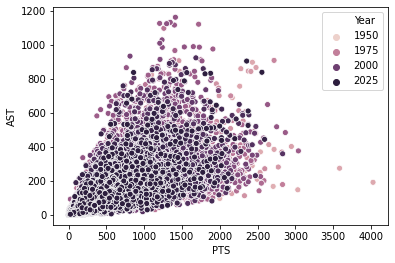

<IPython.core.display.Javascript object>

In [13]:
sns.scatterplot(x="PTS", y="AST", hue="Year", data=nba)
plt.show()

Make a plot showing the trend of median PTS and AST by year.

In [14]:
by_year = nba.groupby("Year").agg({"PTS": "median", "AST": "median"})
by_year = by_year.reset_index()
by_year.head(2)

,Year,PTS,AST
0,1950.0,269.5,67.5
1,1951.0,280.5,69.5


<IPython.core.display.Javascript object>

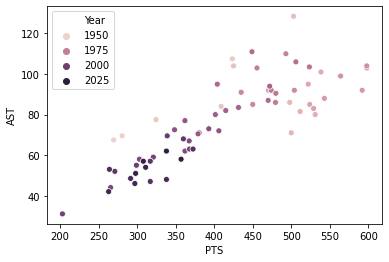

<IPython.core.display.Javascript object>

In [15]:
sns.scatterplot(x="PTS", y="AST", hue="Year", data=by_year)
plt.show()

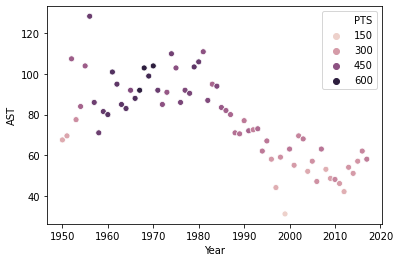

<IPython.core.display.Javascript object>

In [16]:
sns.scatterplot(x="Year", y="AST", hue="PTS", data=by_year)
plt.show()

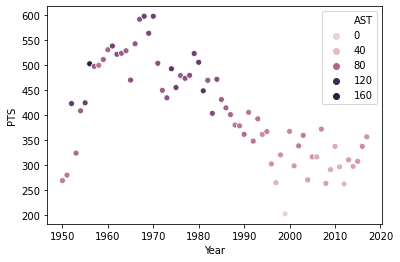

<IPython.core.display.Javascript object>

In [17]:
sns.scatterplot(x="Year", y="PTS", hue="AST", data=by_year)
plt.show()

* List the unique positions.  Which occur the most? the least?
* Filter the dataframe to 'pure' positions (i.e. only keep those like `'PG'` and drop the combined ones like `'PG-SG'`.

In [18]:
pure_pos = nba[~nba["Pos"].str.contains("-")]
pure_pos["Pos"].value_counts()

PF    4966
SG    4811
C     4759
SF    4699
PG    4648
G      139
F      123
Name: Pos, dtype: int64

<IPython.core.display.Javascript object>

In [19]:
# In this case, this is the same
# just be careful of 'magic numbers' (i.e. hardcoded values like 7)
# pure_pos_series = nba["Pos"].value_counts().head(7)
# pure_pos = nba[nba["Pos"].isin(pure_pos_series.index)]

<IPython.core.display.Javascript object>

Let's say we want to know if the number of assists changes based on position.  Create a plot to help us begin investigating this.

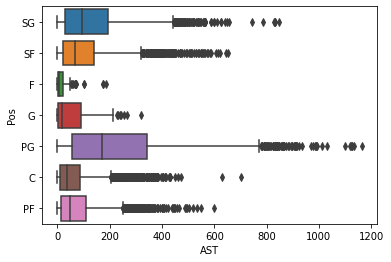

<IPython.core.display.Javascript object>

In [20]:
sns.boxplot("AST", "Pos", data=pure_pos)
plt.show()

It looks like we're pretty safe in saying the point guards get more assists.  Perform a statistical test to confirm this difference.  What test might we use and what do we conclude?

In [21]:
# separate into pg and not pg
pg_ast = pure_pos[pure_pos["Pos"] == "PG"]
not_pg_ast = pure_pos[~(pure_pos["Pos"] == "PG")]

<IPython.core.display.Javascript object>

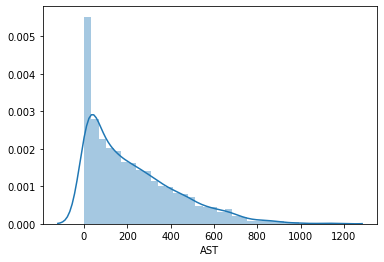

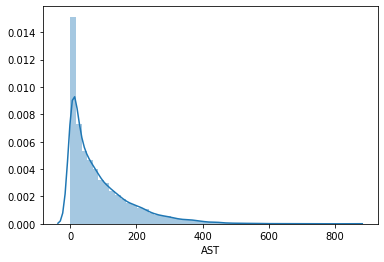

<IPython.core.display.Javascript object>

In [22]:
sns.distplot(pg_ast["AST"])
plt.show()

sns.distplot(not_pg_ast["AST"])
plt.show()

In [23]:
# Not normal, lets go with Mann-Whitney U
_, p = stats.mannwhitneyu(pg_ast["AST"], not_pg_ast["AST"])
print(p)

if p < 0.05:
    print("different medians")
else:
    print("not different medians")

0.0
different medians


<IPython.core.display.Javascript object>

We can also take a step back from our pretty focused analysis (i.e. we've been choosing 1 or 2 variables to look at).  We could instead look at the big picture using something like a heatmap to see what variables are correlated.

In the heatmap, I've intentionally set the range of colors to go from -1 to 1 to map well to potential values of correlation coefficients.

Some things that stick out from this heatmap is the lack of correlation between BLK & AST and BLK & 3P.  Everything else is somewhat positively correlated with one another (this isn't too much of a surprise since they're mostly offensive statistics).  It is of note that PTS seems to be a little more positively correlated with TOV than with any of the other stats.

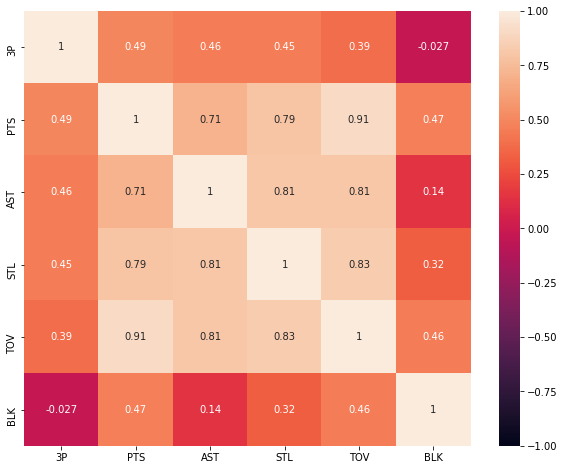

<IPython.core.display.Javascript object>

In [24]:
cols = ["3P", "PTS", "AST", "STL", "TOV", "BLK"]

# Use figure to make it bigger
plt.figure(figsize=(10, 8))
sns.heatmap(nba[cols].corr(), annot=True, vmin=-1, vmax=1)
plt.show()

We could also look at some off the court analysis.  For example, what's the most popular name in the NBA?

In [25]:
# Split into first and last name
nba["first_name"] = nba["Player"].str.split(" ").str[0]
nba["last_name"] = nba["Player"].str.split(" ").str[-1]

<IPython.core.display.Javascript object>

In [26]:
nba["Player"].head(1)

0    Curly Armstrong
Name: Player, dtype: object

<IPython.core.display.Javascript object>

In [27]:
nba["first_name"].head(1)

0    Curly
Name: first_name, dtype: object

<IPython.core.display.Javascript object>

In [28]:
nba["last_name"].head(1)

0    Armstrong
Name: last_name, dtype: object

<IPython.core.display.Javascript object>

In [29]:
# Count the occurances of names
first_name_counts = nba["first_name"].value_counts()
last_name_counts = nba["last_name"].value_counts()

<IPython.core.display.Javascript object>

In [30]:
# Take top n
top_first_names = first_name_counts.head(6).reset_index()
top_last_names = last_name_counts.head(6).reset_index()

<IPython.core.display.Javascript object>

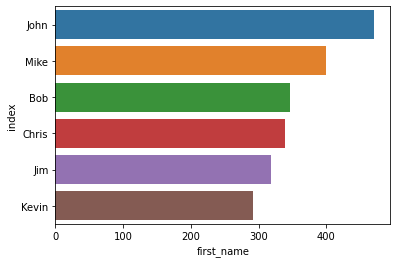

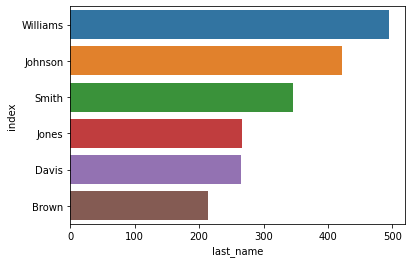

<IPython.core.display.Javascript object>

In [31]:
# Create bar plots
sns.barplot(x="first_name", y="index", data=top_first_names)
plt.show()

sns.barplot(x="last_name", y="index", data=top_last_names)
plt.show()

Plot bonus:

* Pretty up the above barplots.  Give them nice axes labels & titles.  Show these plots horizontally side by side.


----

Going to make up an some stuff to get a contingency table example.  This NBA data doesn't lend itself too well since we pretty much only have numeric data.

Made up example: does handedness correlate with position?  We'll make up the handedness data.

In [32]:
# Removing hyphenated positions
pure_pos = nba[~nba["Pos"].str.contains("-")].copy()

# Randomly assign handedness as left/right
pure_pos["handedness"] = np.random.choice(["L", "R"], pure_pos.shape[0])

crosstab = pd.crosstab(pure_pos["handedness"], pure_pos["Pos"])
crosstab

Pos,C,F,G,PF,PG,SF,SG
handedness,,,,,,,
L,2396,70,79,2450,2323,2342,2445
R,2363,53,60,2516,2325,2357,2366


<IPython.core.display.Javascript object>

In [33]:
crosstab.style.background_gradient(axis="rows")

Pos,C,F,G,PF,PG,SF,SG
handedness,,,,,,,
L,2396,70,79,2450,2323,2342,2445
R,2363,53,60,2516,2325,2357,2366


<IPython.core.display.Javascript object>

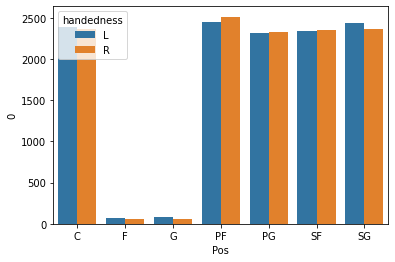

<IPython.core.display.Javascript object>

In [34]:
# Manually counting
counts = pure_pos.groupby(["Pos", "handedness"]).size()
counts = counts.reset_index()

sns.barplot(x="Pos", y=0, hue="handedness", data=counts)
plt.show()

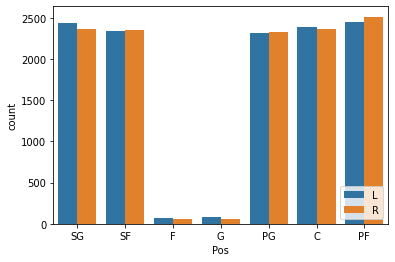

<IPython.core.display.Javascript object>

In [35]:
# sns doing the counting
sns.countplot(x="Pos", hue="handedness", data=pure_pos)
plt.legend(loc="lower right")
plt.show()

In [36]:
# # sns doing the counting
# sns.countplot(x="handedness", hue="Pos", data=pure_pos)
# plt.show()

<IPython.core.display.Javascript object>

Nothing really stands out, we could run a $\chi^2$ (chi square) test to be more formal.  The null hypothesis of a $\chi^2$ test is that there is no relationship between the variables.   Below we see that our pvalue is not below our 5% threshold so we fail to reject the null and conclude that we don't see a relationship between position and handedness.

In [37]:
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
p

0.30064924905720336

<IPython.core.display.Javascript object>

Since we're making up the data anyways, we could manufacture some differences.

In [38]:
# Removing hyphenated positions
pure_pos = nba[~nba["Pos"].str.contains("-")].copy()

# Randomly assign handedness as left/right
pure_pos["handedness"] = np.random.choice(["L", "R"], pure_pos.shape[0])

# Hard code all pg to be righties
# Hard code all sg to be lefties
pure_pos.loc[pure_pos["Pos"] == "PG", "handedness"] = "R"
pure_pos.loc[pure_pos["Pos"] == "SG", "handedness"] = "L"

<IPython.core.display.Javascript object>

Repeat the $\chi^2$ analysis with this new data 